# Check boundary scavenging conditions:

In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import scipy.ndimage as ndimage

%matplotlib notebook

##### Parameters:

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

In [4]:
rimwidth_north = 10

In [5]:
land_color = "#8b7765"

In [6]:
bdyimin, bdyimax = 2168, 2178
bdyjmin, bdyjmax = 201, 798
bdyisize = bdyimax-bdyimin
bdyjsize = bdyjmax-bdyjmin

##### Functions:

In [7]:
def flatten_input(var):
    b = var[0,:,:].flatten()
    for i in range(1,len(var)):
        a = var[i,:,:].flatten()
        b = np.vstack((b,a))
    return b

In [8]:
def create_boundary(rimwidth, boundary_dMn, boundary_oMn):
    
    dMn_O = flatten_input(boundary_dMn)
    oMn_O = flatten_input(boundary_oMn)
    
    dMn_OBC = np.reshape(dMn_O, (1,50,1,np.max(boundary_dMn.shape)*rimwidth))
    oMn_OBC = np.reshape(oMn_O, (1,50,1,np.max(boundary_dMn.shape)*rimwidth))

    return dMn_OBC, oMn_OBC

In [9]:
def save_BC_file(name, dMn_BC, oMn_BC):
    # Setup the new NetCDF file:
    ncd = nc.Dataset('/ocean/brogalla/GEOTRACES/data/'+name, 'w', zlib=True)
    ncd.createDimension('x', np.max(dMn_BC.shape))
    ncd.createDimension('y',1)
    ncd.createDimension('z',50)
    ncd.createDimension('t',None)
    
    dMn = ncd.createVariable('dMn', 'float64', ('t','z','y','x'))
    dMn.units = 'dissolved Mn'
    dMn.long_name = 'dMn'
    dMn[:] = dMn_BC

    oMn = ncd.createVariable('oMn', 'float64', ('t','z','y','x'))
    oMn.units = 'oxidised Mn'
    oMn.long_name = 'oMn'
    oMn[:] = oMn_BC
    
    ncd.close()
    return

##### Load files:

In [10]:
ref       = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2015m01d05.nc',  'r')
lat_model = np.array(ref.variables['nav_lat'])
lon_model = np.array(ref.variables['nav_lon'])

In [147]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'])[0,bdyimin:bdyimax,bdyjmin:bdyjmax]
mbathy     = np.array(mesh.variables['tmask'])[0,:,bdyimin:bdyimax,bdyjmin:bdyjmax]
mesh_depth = np.array(mesh.variables['nav_lev'])

In [12]:
N_lats = lat_model[bdyimin:bdyimax,bdyjmin:bdyjmax]
N_lons = lon_model[bdyimin:bdyimax,bdyjmin:bdyjmax]

In [186]:
# inif = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_ini_20190802.nc')
# ini_dMn = np.array(inif.variables['dMn'])[0,:,bdyimin:bdyimax,bdyjmin:bdyjmax]
# ini_oMn = np.array(inif.variables['oMn'])[0,:,bdyimin:bdyimax,bdyjmin:bdyjmax]

inif = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-spin-up7/ANHA12_EXH006_2002_monthly.nc')
ini_dMn = np.array(inif.variables['dissolmn'])[5,0,:,bdyimin-imin:bdyimax-imin,bdyjmin-jmin:bdyjmax-jmin]
ini_oMn = np.array(inif.variables['oxidismn'])[5,0,:,bdyimin-imin:bdyimax-imin,bdyjmin-jmin:bdyjmax-jmin]

##### Calculations and Figures:

In [ ]:
def create_BC(label, bdyimin,bdyimax,bdyjmin,bdyjmax)
    
    # Load data from end of spin up period:
    inif = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-spin-up7/ANHA12_EXH006_2002_monthly.nc')
    ini_dMn = np.array(inif.variables['dissolmn'])[5,0,:,bdyimin-imin:bdyimax-imin,bdyjmin-jmin:bdyjmax-jmin]
    ini_oMn = np.array(inif.variables['oxidismn'])[5,0,:,bdyimin-imin:bdyimax-imin,bdyjmin-jmin:bdyjmax-jmin]
    
    
    if label=='North':
        

    return

Because the global model oMn concentrations are not correct for our region (much too low), we use values for the boundary conditions from the end of the spin up period from our model run at 20 gridpoints interior from the boundary.

In [204]:
# Boundary conditions:
dMn_north1 = np.copy(ini_dMn)
oMn_north1 = np.copy(ini_oMn)
dMn_north1[3:15,:,240:295] = 8.5e-9
oMn_north1[3:15,:,240:295] = 1.5e-9

for z in range(0,50):
    # Replace zero values:
    dMn_north1[dMn_north == 0] = np.average(dMn_north1[z,:,:])
    oMn_north1[oMn_north == 0] = np.average(oMn_north1[z,:,:])
    
    # Replace ratios that are off:
    dMn_north1[(dMn_north/oMn_north) > 50] = np.average(dMn_north1[z,:,:])
    oMn_north1[(dMn_north/oMn_north) > 50] = np.average(oMn_north1[z,:,:])

# # Low background concentration in land areas:
# dMn_north1[(mbathy < 0.1)] = 0.2e-9
# oMn_north1[(mbathy < 0.1)] = 0.2e-9

# Filter to smoothe out the forcing
dMn_north = ndimage.gaussian_filter(dMn_north1, sigma=4, order=0)
oMn_north = ndimage.gaussian_filter(oMn_north1, sigma=4, order=0)

<IPython.core.display.Javascript object>


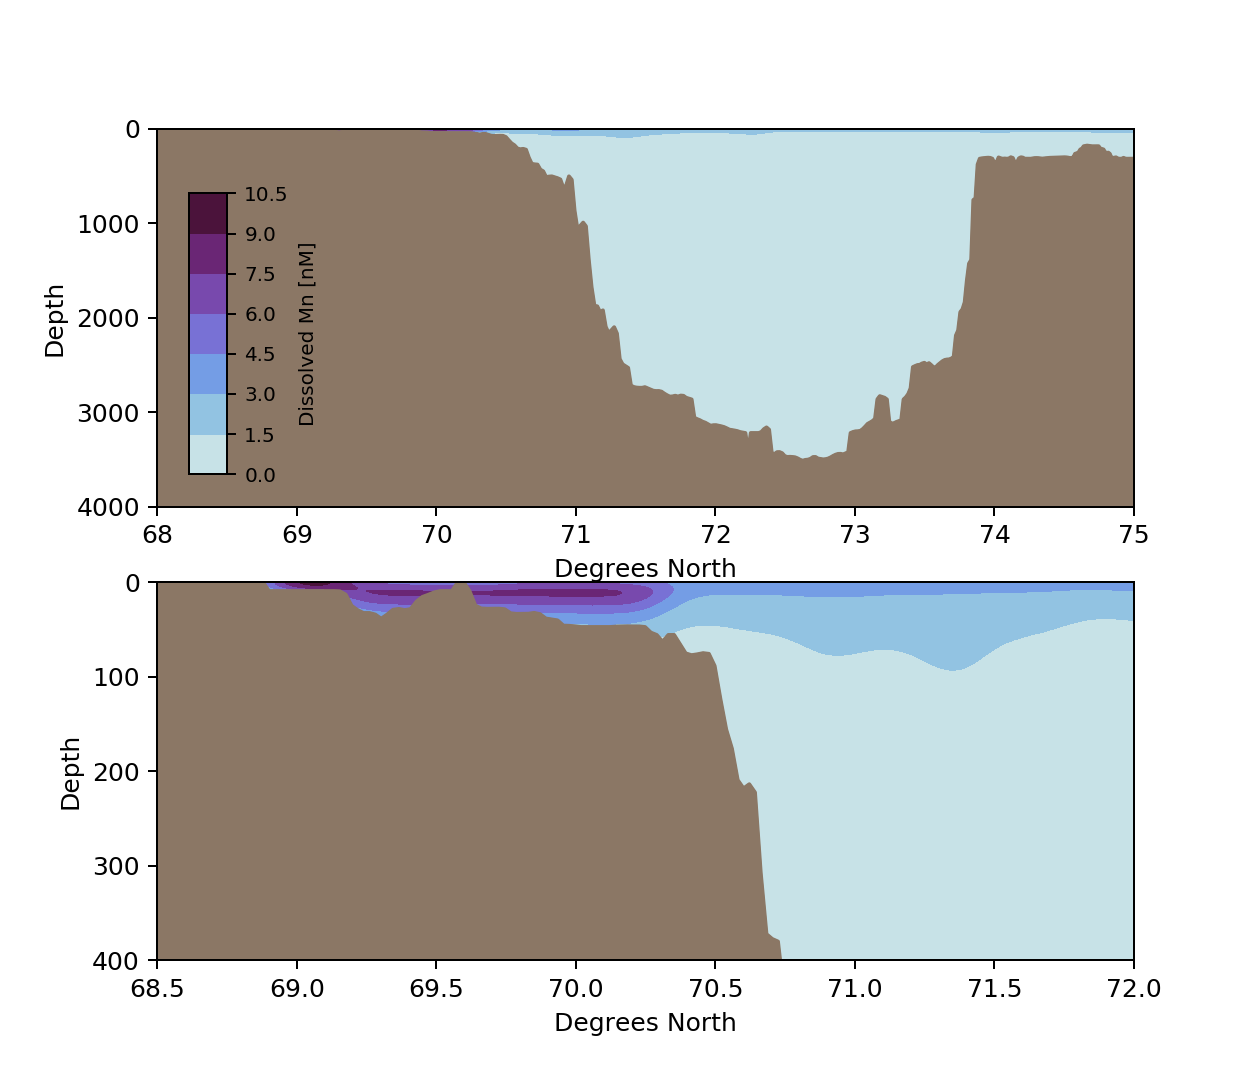

In [200]:
layer=1

fig, ax = plt.subplots(2,1, figsize=(7,6))

for axes in ax:
    axes.invert_yaxis()
    axes.plot(N_lats[layer,:], mesh_bathy[layer,:], c=land_color,zorder=2)
    axes.fill_between(N_lats[layer,:], 4000, mesh_bathy[layer,:], color=land_color, zorder=2)
    axes.set_xlabel('Degrees North')
    axes.set_ylabel('Depth')
    contour = axes.contourf(N_lats[layer,:], mesh_depth, dMn_north[:,layer,:]*1e9, \
                            cmap=cmocean.cm.dense, zorder=1)

ax[0].set_xlim(68, 75)
ax[0].set_ylim(4000, 0)
ax[1].set_xlim(68.5, 72)
ax[1].set_ylim(400, 0)

cbar_ax = fig.add_axes([0.15, 0.56, 0.03, 0.26])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Dissolved Mn [nM]', fontsize=8) 
cbar_ax.tick_params(axis='both', which='major', labelsize=8)

<IPython.core.display.Javascript object>


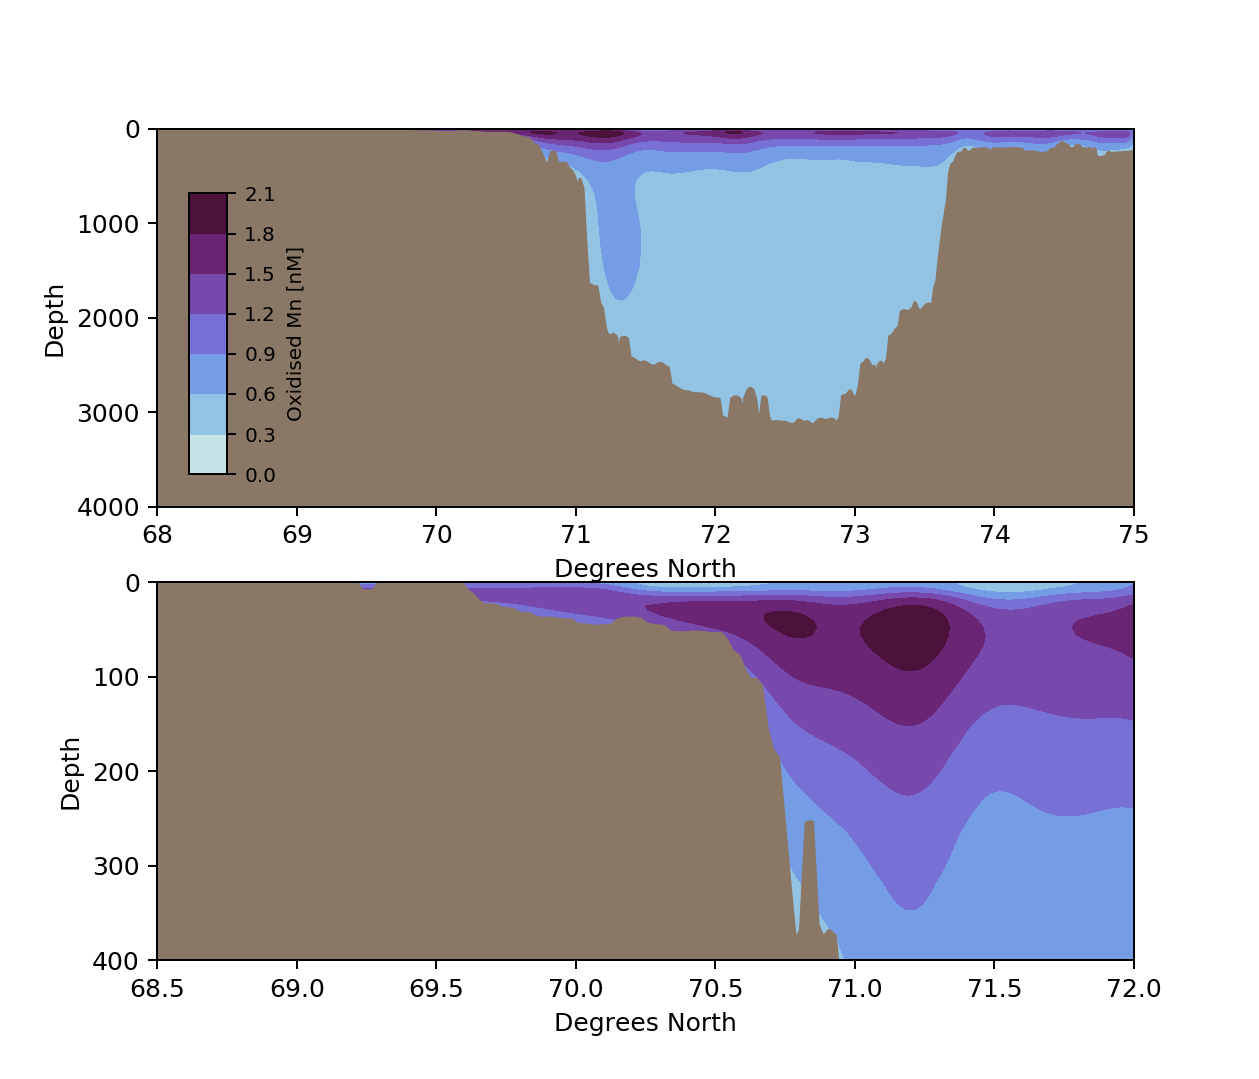

In [205]:
layer=5

fig, ax = plt.subplots(2,1, figsize=(7,6))

for axes in ax:
    axes.invert_yaxis()
    axes.plot(N_lats[layer,:], mesh_bathy[layer,:], c=land_color,zorder=2)
    axes.fill_between(N_lats[layer,:], 4000, mesh_bathy[layer,:], color=land_color, zorder=2)
    axes.set_xlabel('Degrees North')
    axes.set_ylabel('Depth')
    contour = axes.contourf(N_lats[layer,:], mesh_depth, oMn_north[:,layer,:]*1e9, \
                            cmap=cmocean.cm.dense, zorder=1)

ax[0].set_xlim(68, 75)
ax[0].set_ylim(4000, 0)
ax[1].set_xlim(68.5, 72)
ax[1].set_ylim(400, 0)

cbar_ax = fig.add_axes([0.15, 0.56, 0.03, 0.26])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Oxidised Mn [nM]', fontsize=8) 
cbar_ax.tick_params(axis='both', which='major', labelsize=8)

<IPython.core.display.Javascript object>


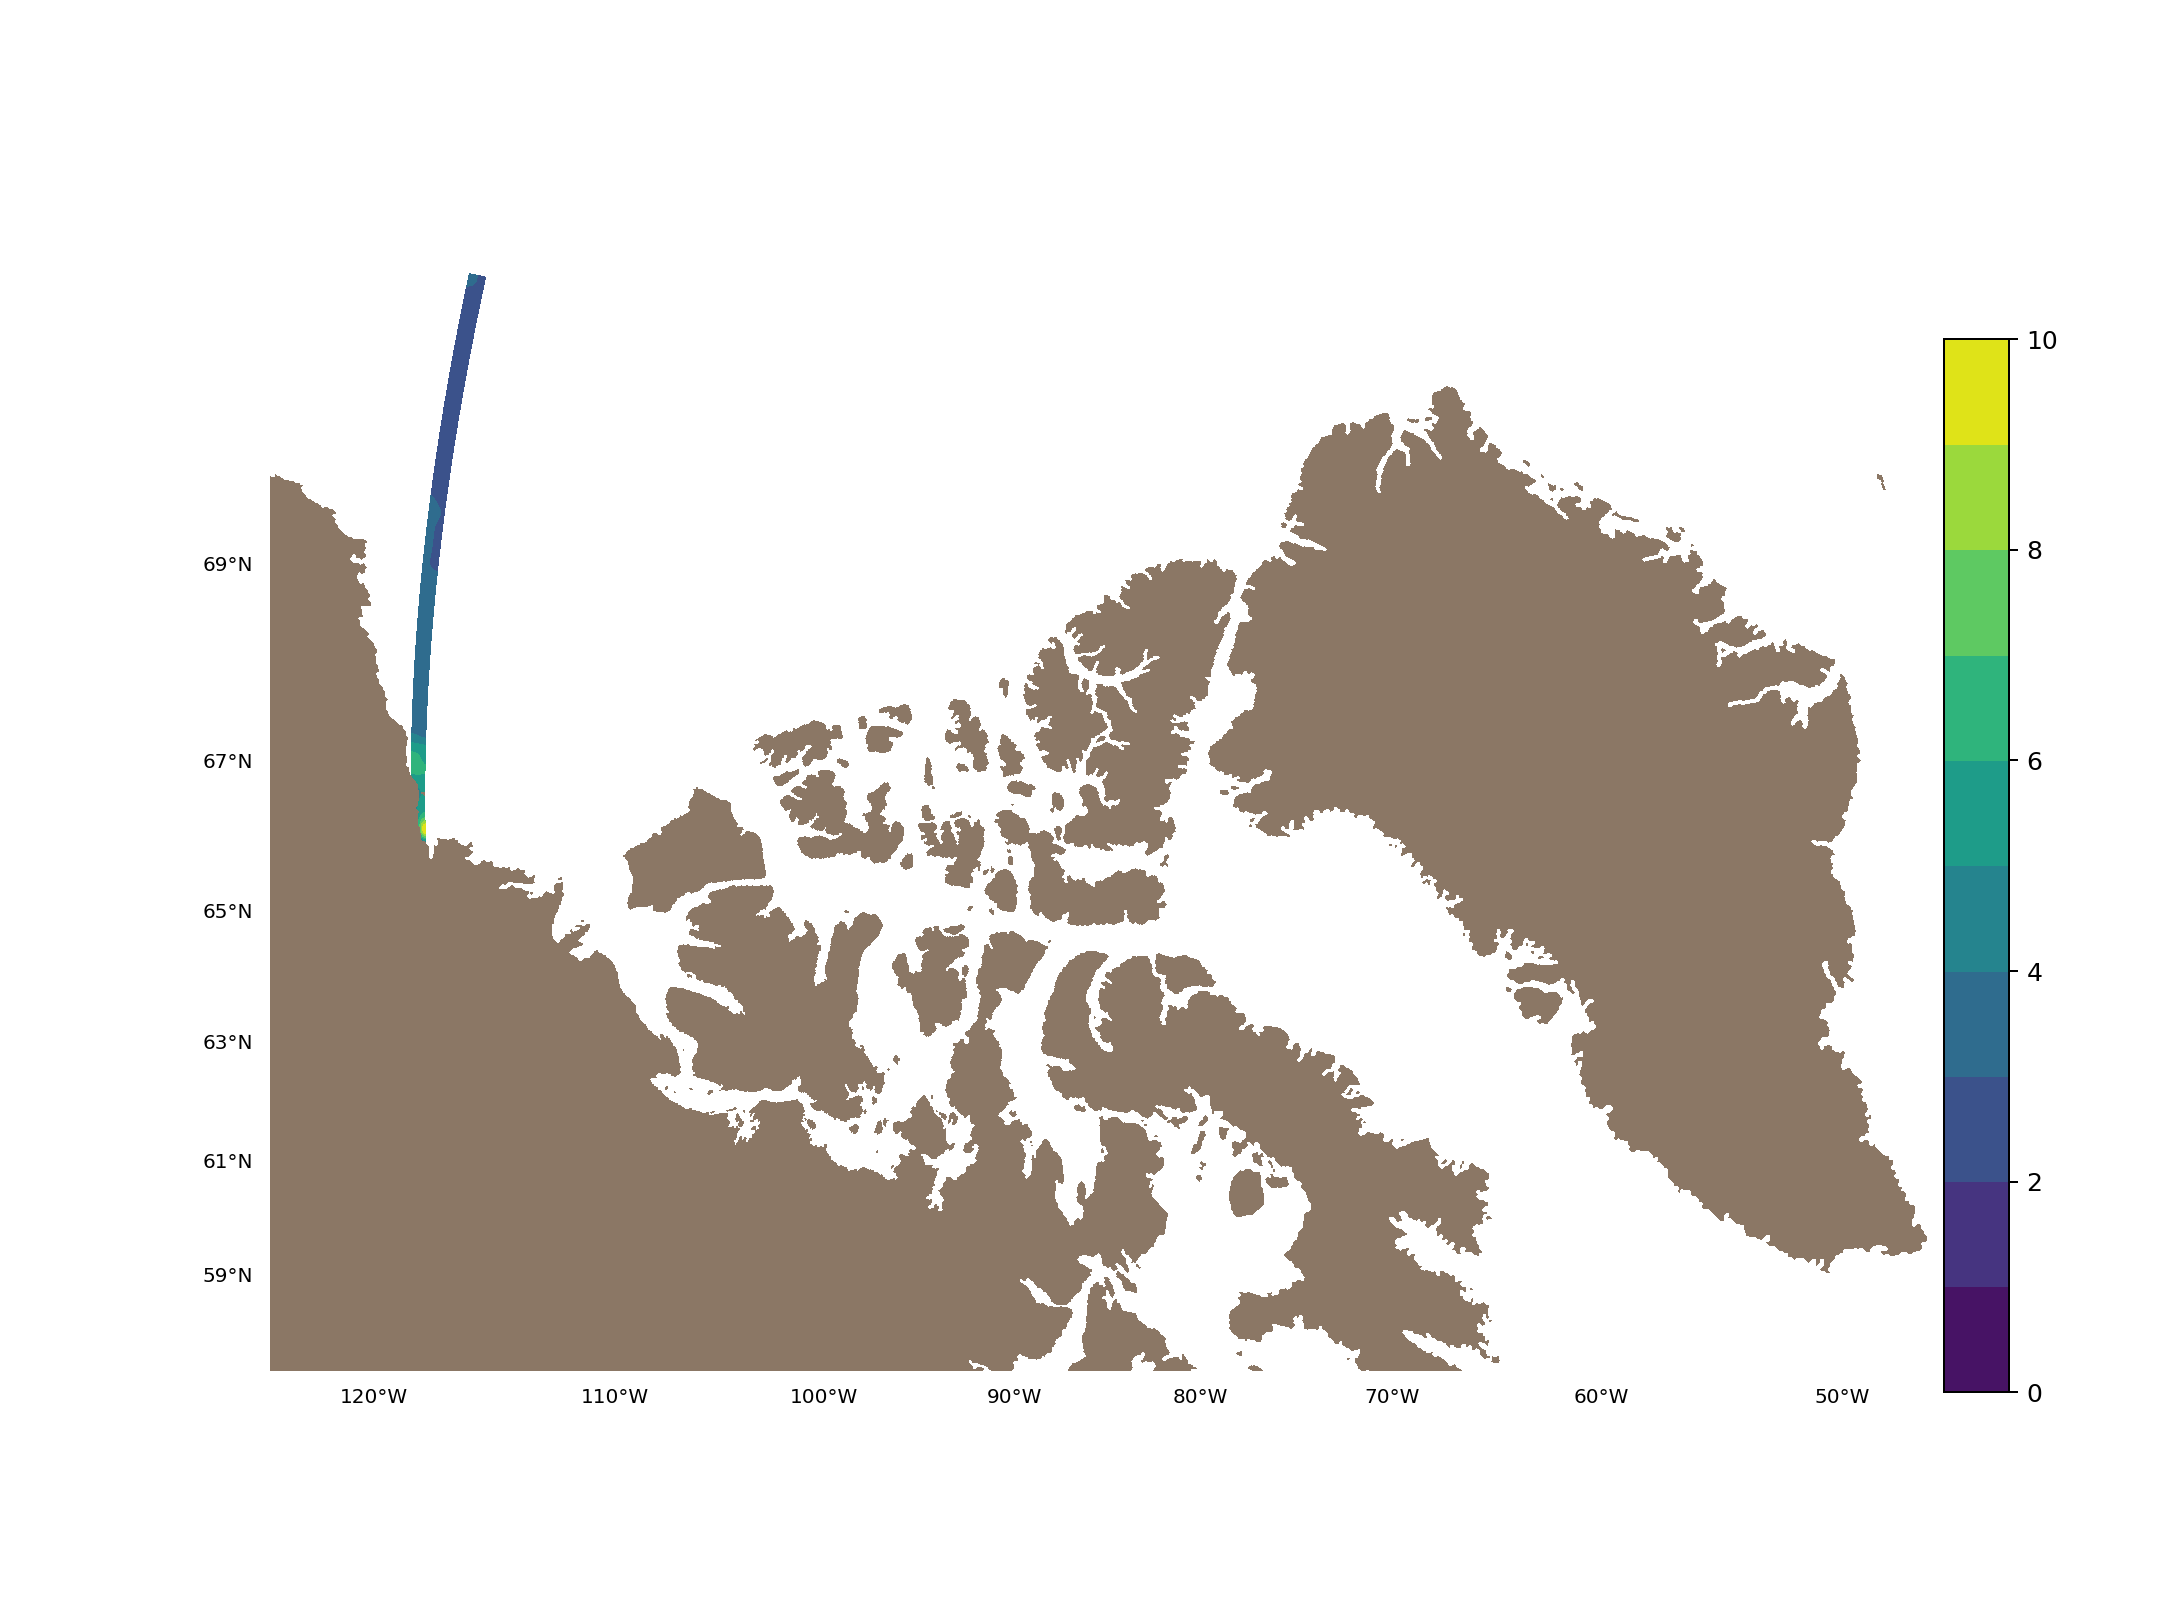

In [206]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))
#-----------------------------------------------------------------------------

xN, yN = proj1(lon_model[2168:2178, 201:798], lat_model[2168:2178, 201:798])
CB1 = proj1.contourf(xN, yN, dMn_north[0,:,:]*10**9, 10, vmin=0, vmax=10)

cbaxes = fig.add_axes([0.90, 0.14, 0.03, 0.65]) 
CBar = plt.colorbar(CB1, ax=ax1, cax=cbaxes) 

#### Mask land areas with a low background concentration

In [207]:
dMn_north[(mbathy < 0.1)] = 0.2e-9
dMn_north[(mbathy < 0.1)] = 0.2e-9

#### Write final boundary condition:

In [208]:
dMn_north_BC, oMn_north_BC = create_boundary(rimwidth_north, dMn_north, oMn_north)
dMn_north_BC, oMn_north_BC = create_boundary(rimwidth_north, dMn_north, oMn_north)

In [209]:
save_BC_file('Mn_North_OBC_20201214.nc', dMn_north_BC, oMn_north_BC)